# Initial codes

This notebook illustrates how Bayesian inference can be used to infer response rates of each group (basket) in a Basket trial.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
from pyBasket.env import Trial

## Example 1: treatment is of interest in all groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 1).

4 groups are present in the trial, and all group response rates to the treatment are the same (0.3). The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The first example is a scenario in which responses are simulated assuming p = 30% in all four groups. This example illustrates the effect of borrowing across groups when all groups are similar, such as the smoothing of the observed response rates and a reduction in uncertainty.

### Generate data

In [4]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p1, p1, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage
num_burn_in = 1E5
num_posterior_samples = 1E5
model_names = ['independent', 'hierarchical', 'bhm']

DEBUG = True

In [12]:
if DEBUG:
    evaluate_interim = [True, True, False, False, False, True]
    num_burn_in = 1E4
    num_posterior_samples = 1E4
    model_names = ['independent', 'hierarchical', 'bhm']

In [16]:
trial = Trial(K, p0, p1, true_response_rates, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, model_names)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########
Group 0 (true θ=0.30) [1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Group 2 (true θ=0.30) [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 37 seconds.



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 46 seconds.



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tausq, theta0, e]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.



########## Stage=1 Enrolled = 15 ##########
Group 0 (true θ=0.30) [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 31 seconds.



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 39 seconds.



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tausq, theta0, e]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 36 seconds.



########## Stage=2 Enrolled = 20 ##########
Group 0 (true θ=0.30) [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Group 2 (true θ=0.30) [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]


########## Stage=3 Enrolled = 25 ##########
Group 0 (true θ=0.30) [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Group 2 (true θ=0.30) [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


########## Stage=4 Enrolled = 30 ##########
Group 0 (true θ=0.30) [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Group 1 (true θ=0.30) [0, 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 31 seconds.



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 38 seconds.



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tausq, theta0, e]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 38 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### Check last results

### Independent

In [17]:
model_name = model_names[0]

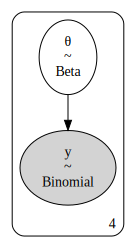

In [18]:
trial.visualise_model(model_name)

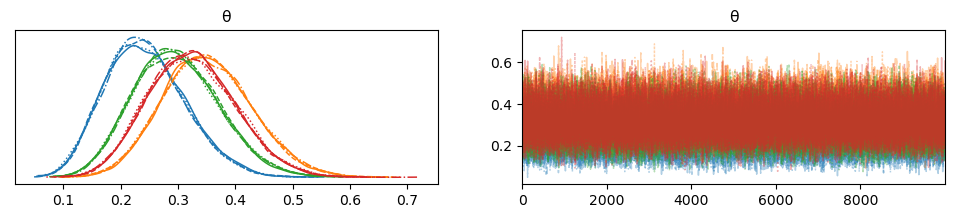

In [19]:
trial.plot_trace(model_name, -1)

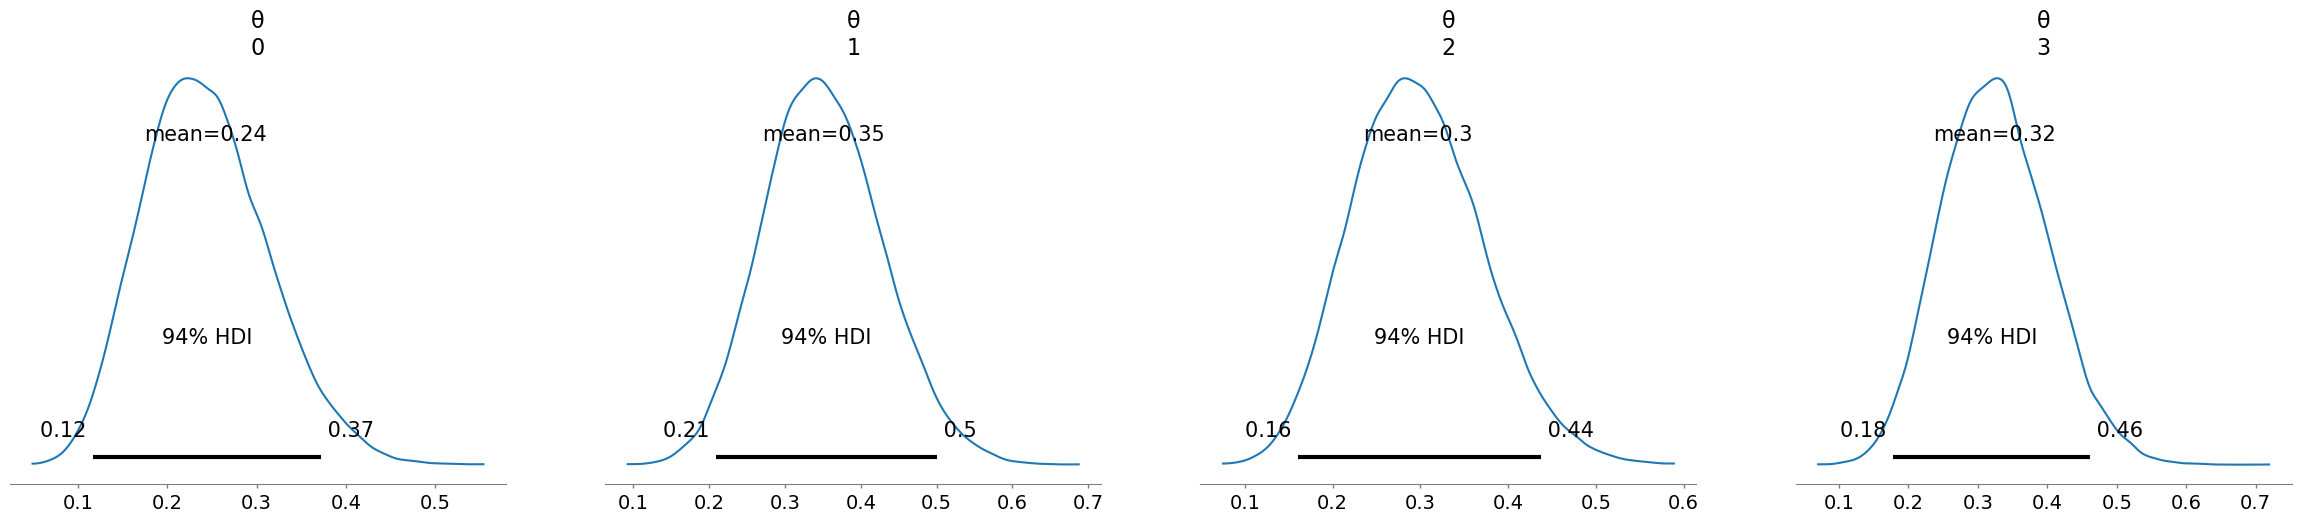

In [20]:
trial.plot_posterior(model_name, -1)

Check early stopping

In [21]:
trial.inference_results

defaultdict(list,
            {'independent': [<pyBasket.env.Independent at 0x171df21a0>,
              None,
              None,
              None,
             'hierarchical': [<pyBasket.env.Hierarchical at 0x17135d810>,
              None,
              None,
              None,
             'bhm': [<pyBasket.env.BHM at 0x171b33010>,
              None,
              None,
              None,
              <pyBasket.env.BHM at 0x1711b7820>]})

### Hierarchical

In [ ]:
model_name = model_names[1]

In [ ]:
trial.visualise_model(model_name)

In [ ]:
trial.plot_trace(model_name, -1)

In [ ]:
trial.plot_posterior(model_name, -1)

### BHM

In [ ]:
model_name = model_names[2]

In [ ]:
trial.visualise_model(model_name)

In [ ]:
trial.plot_trace(model_name, -1)

In [ ]:
trial.plot_posterior(model_name, -1)

## Example 2: treatment is of interest in only two groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 2).

4 groups are present in the group, with first two group responses = 0.10 and the other two groups = 0.3. The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The second example is from a scenario in which responses are simulated assuming p = 10% in two groups and p = 30% in two groups. This example illustrates the effect of borrowing, and that the harm is not great, when groups are dissimilar.

### Generate data

In [ ]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p0, p0, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [False, False, False, False, False, True] # only evaluate in the last stage
# evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage

num_burn_in = 1E5
num_posterior_samples = 1E5
model_names = ['independent', 'hierarchical', 'bhm']

In [ ]:
trial = Trial(K, p0, p1, true_response_rates, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, model_names)

done = trial.reset()
while not done:
    done = trial.step()

### Check last results

### Independent

In [ ]:
model_name = model_names[0]

In [ ]:
trial.visualise_model(model_name)

In [ ]:
trial.plot_trace(model_name, -1)

In [ ]:
trial.plot_posterior(model_name, -1)

### Hierarchical

In [ ]:
model_name = model_names[1]

In [ ]:
trial.visualise_model(model_name)

In [ ]:
trial.plot_trace(model_name, -1)

In [ ]:
trial.plot_posterior(model_name, -1)

### BHM

In [ ]:
model_name = model_names[2]

In [ ]:
trial.visualise_model(model_name)

In [ ]:
trial.plot_trace(model_name, -1)

In [ ]:
trial.plot_posterior(model_name, -1)